<a href="https://colab.research.google.com/github/ayodejitoriola/use/blob/main/image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from google.colab import  drive
import zipfile
import os


In [2]:
#mount drive
if not os.path.exists("content/drive"):
  drive.mount("/content/drive")
else:
  print("Drive already Mounted")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
zip_file_path= "/content/drive/MyDrive/archive (1).zip"
unzip_data_path="/content/image_data"
if not os.path.exists(unzip_data_path):
  os.makedirs(unzip_data_path)
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
  zip_ref.extractall(unzip_data_path)

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets

raw_data= datasets.ImageFolder("/content/image_data")
raw_data

Dataset ImageFolder
    Number of datapoints: 5981
    Root location: /content/image_data

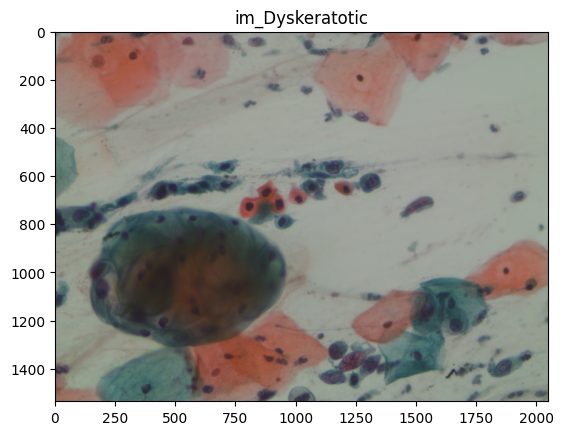

In [5]:
image, label= raw_data[0]
plt.imshow(image)
plt.title(raw_data.classes[label])
plt.show()

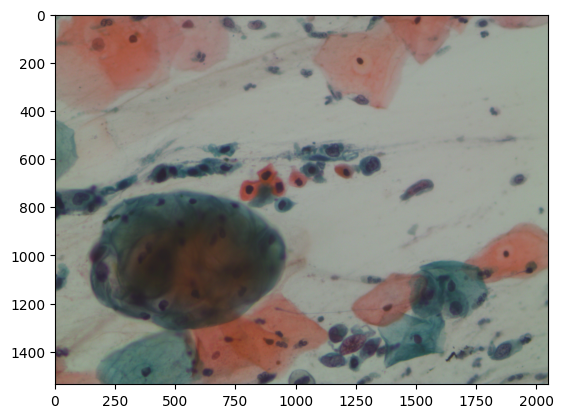

In [6]:
bmp_file_path = "/content/image_data/im_Dyskeratotic/im_Dyskeratotic/001.bmp"
image=Image.open(bmp_file_path)
plt.imshow(image)

In [7]:
import shutil
def extract_bmp(Input_dir, output_dir):
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)
  for filename in os.listdir(Input_dir):
    if filename.endswith(".bmp"):
      file_path=os.path.join(Input_dir, filename)
      shutil.move(file_path, output_dir)

In [8]:
extract_bmp("/content/image_data/im_Dyskeratotic/im_Dyskeratotic", "/content/image_data/main_im_Dyskeratotic")

Error: Destination path '/content/image_data/main_im_Dyskeratotic/075.bmp' already exists

In [ ]:
extract_bmp("/content/image_data/im_Koilocytotic/im_Koilocytotic", "/content/image_data/main_im_Koilocytotic")
extract_bmp("/content/image_data/im_Metaplastic/im_Metaplastic", "/content/image_data/main_im_Metaplastic")
extract_bmp("/content/image_data/im_Parabasal/im_Parabasal", "/content/image_data/main_im_Parabasal")
extract_bmp("/content/image_data/im_Superficial-Intermediate/im_Superficial-Intermediate", "/content/image_data/main_im_Superficial-Intermediate")

In [ ]:
for folder in os.listdir("/content/image_data"):
  if folder.startswith("im"):
    !rm -rf "/content/image_data/$folder"

In [ ]:
normal_dirs=["/content/image_data/main_im_Metaplastic","/content/image_data/main_im_Superficial-Intermediate"]
abnormal_dirs=["/content/image_data/main_im_Dyskeratotic","/content/image_data/main_im_Koilocytotic",
               "/content/image_data/main_im_Parabasal"]

# function to label the dataset as normal and abnormal
def label_dataset(base_dirs, label):
  labeled_images= []
  for dir in base_dirs:
    for image in os.listdir(dir):
      image_path= os.path.join(dir, image)
      if image.endswith(".bmp"):
        labeled_images.append((image_path, label))
  return labeled_images
#Labelling datasets (normal =0 , abnormal =1)
normal_images= label_dataset(normal_dirs, 0)
abnormal_images= label_dataset(abnormal_dirs, 1)
# Combining all images
all_images = normal_images + abnormal_images

# Shuffling the dataset
import random
random.shuffle(all_images)


In [ ]:
len(all_images)

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import torch
class imageClass(Dataset):
  def __init__(self, data, transform=None):
    self.data= data
    self.transform= transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    image_path, label= self.data[index]
    image= Image.open(image_path)
    if self.transform:
      image= self.transform(image)
    return image, label

transform= transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset= imageClass(all_images, transform=transform)

In [ ]:
bmp_file_path = all_images[0][0]
image=Image.open(bmp_file_path)
plt.imshow(image)

In [ ]:
from torch.utils.data import DataLoader, random_split
print(len(dataset))
train_size = int(0.7* len(dataset))
test_size = len(dataset) - train_size
print(train_size,test_size)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=32, shuffle=False)

len(train_dataset), len(test_dataset)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
class simpleCNN(nn.Module):
  def __init__(self):
    super(simpleCNN, self).__init__()
    self.conv1= nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
    self.conv2= nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.pool= nn.MaxPool2d(kernel_size=2, stride=2)
    #self.conv3= nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.ln1=nn.Linear(32*56*56, 128)
    self.ln2=nn.Linear(128, 2)


  def forward(self, x):
    x= self.pool(torch.relu(self.conv1(x)))
    x= self.pool(torch.relu(self.conv2(x)))
    x= x.view(-1, 32*56*56)
    x= torch.relu(self.ln1(x))
    x= self.ln2(x)

    return x
model = simpleCNN()
criterion = nn.CrossEntropyLoss()
optimer= optim.Adam(model.parameters(), lr=0.001)

def train(model, criterion, optimizer, data_loader, epochs=5):
  for epoch in range(epochs):
    model.train()
    for images, labels in data_loader:
      optimizer.zero_grad()
      outputs= model(images)
      loss= criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    print(loss)

def evaluate(model, data_loader):
  model.eval()
  correct=0
  total=0
  with torch.no_grad():
    for images, labels in data_loader:
      outputs= model(images)
      predicted =torch.max(outputs.data,1)[1]
      total+=labels.size(0)
      correct+= (predicted == labels).sum().item()
  return 100* correct/total

In [ ]:
train(model, criterion, optimer, train_loader)

In [ ]:
print(evaluate(model, test_loader))
evaluate(model, train_loader)


In [ ]:
from torchvision import models

model = models.resnet50(weights='DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

class earlystopping():
  def __init__(self, patience=5, min_delta=0):
    self.patience= patience
    self.min_delta= min_delta
    self.counter=0
    self.best_loss= None
    self.early_acc= None

  def __call__(self, val_loss, val_acc):
    if self.best_loss == None:
      self.best_loss= val_loss
      self.best_acc= val_acc
num_epochs=30
early_stopping = earlystopping()

for epoch in range(num_epochs):
  model.train()
  for images, labels in train_loader:
    images = images.to(device)
    labels= labels.to(device)
    output= model(images)

    optimizer.zero_grad()
    loss= criterion(output, labels)
    loss.backward()
    optimizer.step()
  print(loss)



In [ ]:
def evaluate(model, data_loader):
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
      for images, labels in data_loader:
        images = images.to(device)
        labels= labels.to(device)
        outputs= model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+=labels.size(0)
        correct+= (predicted == labels).sum().item()
    accuracy = 100* correct/total
    print(accuracy)

In [ ]:
print(evaluate(model, test_loader))
evaluate(model, train_loader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# EfficientNet
def efficientnet(num_classes=2, pretrained=True):
    model = models.efficientnet_b0(pretrained=pretrained)  # You can choose b0, b1, etc.
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)  # Replace final layer
    return model

# AlexNet
def alexnet(num_classes=2, pretrained=True):
    model = models.alexnet(pretrained=pretrained)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)  # Replace final layer
    return model

efficientnet_model = efficientnet(num_classes=2)
alexnet_model = alexnet(num_classes=2)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_efficientnet = optim.Adam(efficientnet_model.parameters(), lr=0.001)
optimizer_alexnet = optim.Adam(alexnet_model.parameters(), lr=0.001)

# Training loop stays the same as your `train` function
def train(model, criterion, optimizer, data_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        for images, labels in data_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [ ]:
train(efficientnet_model, criterion, optimizer_efficientnet, train_loader, epochs=5)

In [ ]:
train(alexnet_model, criterion, optimizer_alexnet, train_loader, epochs=5)

In [ ]:
print(evaluate(efficientnet_model, test_loader))
evaluate(alexnet_model, test_loader)